In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import utils.metrics as metrics
from regions import southeast_us, pacific_nw
from datasource import NoaaLivnehDataLoader
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [2]:
data = NoaaLivnehDataLoader(gcs_bucket='noaa-livneh', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# NOAA 20th century reanalysis
noaa = xr.open_zarr(data.noaa20cr(), consolidated=True).clip(min=0.0, max=np.inf)
livneh = xr.open_zarr(data.livneh(), consolidated=True).clip(min=0.0, max=np.inf)
def get_train_test_splits(data_lo, data_hi, region_fn, scale):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
    lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
    hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    return lr_train, lr_test, hr_train, hr_test

In [3]:
noaa

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 12783)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2015-12-31
Data variables:
    pr       (time, lat, lon) float64 dask.array<chunksize=(1000, 60, 60), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1000, 60, 60), meta=np.ndarray>

In [4]:
livneh

<xarray.Dataset>
Dimensions:  (lat: 614, lon: 928, time: 23376)
Coordinates:
  * lat      (lat) float64 14.66 14.72 14.78 14.84 ... 52.78 52.84 52.91 52.97
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 ... -67.16 -67.09 -67.03
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(487, 307, 232), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(487, 307, 232), meta=np.ndarray>

In [5]:
noaa_seus = southeast_us(noaa)['tasmax']
livneh_seus = southeast_us(livneh, scale_factor=16, lon_west=True)['tasmax']
print(noaa_seus)
print(livneh_seus)

<xarray.DataArray 'tasmax' (time: 12783, lat: 8, lon: 16)>
dask.array<getitem, shape=(12783, 8, 16), dtype=float32, chunksize=(1000, 6, 16), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0
  * lon      (lon) float32 267.0 268.0 269.0 270.0 ... 279.0 280.0 281.0 282.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2015-12-31
<xarray.DataArray 'tasmax' (time: 23376, lat: 128, lon: 256)>
dask.array<getitem, shape=(23376, 128, 256), dtype=float32, chunksize=(487, 94, 185), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 27.97 28.03 28.09 28.16 ... 35.72 35.78 35.84 35.91
  * lon      (lon) float64 -93.03 -92.97 -92.91 -92.84 ... -77.22 -77.16 -77.09
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31


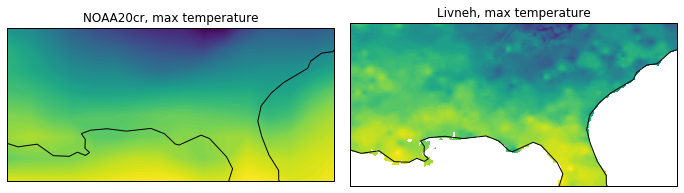

In [6]:
fig, axs, plot_fn = image_map_factory(1, 2, figsize=(6,4))
plot_fn(axs[0], noaa_seus[0], noaa_seus.lat, noaa_seus.lon, title='NOAA20cr, max temperature', cmap='viridis')
plot_fn(axs[1], livneh_seus[0], livneh_seus.lat, livneh_seus.lon, title='Livneh, max temperature', cmap='viridis')

In [15]:
livneh_seus.interpolate_na(dim='lat', method='linear').values[0]

ValueError: dimension 'lat' on 1th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, rechunk into a single dask array chunk along this dimension, i.e., ``.chunk({'lat': -1})``, but beware that this may significantly increase memory usage.